In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
def parse_dat_file_to_dataframe(file_path):
    # List to store event data (each event is a dict)
    events_data = []
    current_event = {}
    event_number = None

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing spaces
            
            # Detect the start of a new event
            event_match = re.match(r'% Event (\d+)', line)
            if event_match:
                # If we are in the middle of an event, store it before moving to the next one
                if current_event:
                    events_data.append(current_event)
                    current_event = {}
                
                # Start a new event
                event_number = int(event_match.group(1))
                current_event['Event'] = event_number
            
            # Split the key-value pairs and store them in the current_event dict
            elif line and not line.startswith('%'):
                key_value = line.split('\t')
                if len(key_value) == 2:
                    key, value = key_value
                    current_event[key] = float(value) if value.replace('.', '', 1).isdigit() else value

        # Append the last event after reading the file
        if current_event:
            events_data.append(current_event)
    
    # Convert list of event dictionaries to a DataFrame
    df = pd.DataFrame(events_data)
    
    return df

In [3]:
folder = "O:/Nat_ASVAP/OMLAB_DATA/ASVAP_press_"
month = "Oct2024/"
run = "Run-005"

start_file = 1
path_intial = folder+month+run+"/"+run+f"-00{start_file}.dat"
path = folder+month+run
num_files = 11


In [4]:
df = parse_dat_file_to_dataframe(path_intial)
for i in range(start_file+1,num_files+1):
    
    if i <10:
        next_file = parse_dat_file_to_dataframe(path+"/"+run+f"-00{i}.dat")
    elif 10 <= i <100:
        next_file = parse_dat_file_to_dataframe(path+"/"+run+f"-0{i}.dat")
    elif 100 <= i:
        next_file = parse_dat_file_to_dataframe(path+"/"+run+f"-{i}.dat")
    df = pd.concat([df,next_file],ignore_index=True)
zero_indices = df.index[df['Some_calibration'] == 0.0].tolist()
df = df.drop(index=zero_indices).reset_index(drop=True)

In [7]:
def linfunc(x, a, b):
    return x*a + b

def expfunc(x, a, b ,c):
    return a* np.exp(b * x ) + c

def lnfunc(x,a,b,c):
    return  a*np.log(b*x) + c

intial_guess = [10,-4,20]

data_start, data_stop =0,-1

func = expfunc

xdata = ((df["Time_ms"]-df["Time_ms"][0])*2.7778*10**(-7)) #Time in hours
# ydata = df["TC_CH8_TransCh_C"]#.astype(float) * 10**(-7) #convert to 1e-7 mbar
ydata = df["TC_CH7_TopWin_C"].astype(float)
popt, pcov = curve_fit(func, xdata[data_start:data_stop],ydata[data_start:data_stop], p0=intial_guess, maxfev=10000 )
print(popt, np.diag(pcov))

[ 25.11706431 -22.37614922  -5.11827465] [1.02076599e-03 2.61729062e-03 7.98777912e-05]


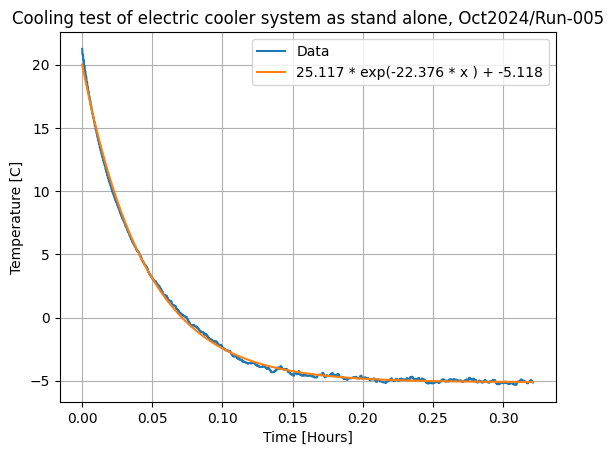

In [14]:
plt.plot(xdata,ydata, label="Data")
if func == expfunc:
    plt.plot(xdata[data_start:data_stop], expfunc(xdata[data_start:data_stop],*popt), label="{:.3f} * exp({:.3f} * x ) + {:.3f}".format(*popt))
elif func == linfunc:
    plt.plot(xdata, linfunc(xdata,*popt), label="{:.7f}*x + {:.7f}".format(*popt))
elif func == lnfunc:
    plt.plot(xdata[data_start:data_stop], lnfunc(xdata[data_start:data_stop], *popt), label="{} * ln({} * x) + {}".format(*popt))
plt.xlabel("Time [Hours]")
plt.ylabel("Temperature [C]")
plt.grid()
plt.legend()
# plt.xscale("log")
plt.title("Cooling test of electric cooler system as stand alone, {}".format(month+run))
# plt.savefig("Plots/heating of sample holder to 35 C Oct run 3")
# plt.savefig("Plots/Cooling electric system test Oct 2024 run 005")

-5.118274646113658


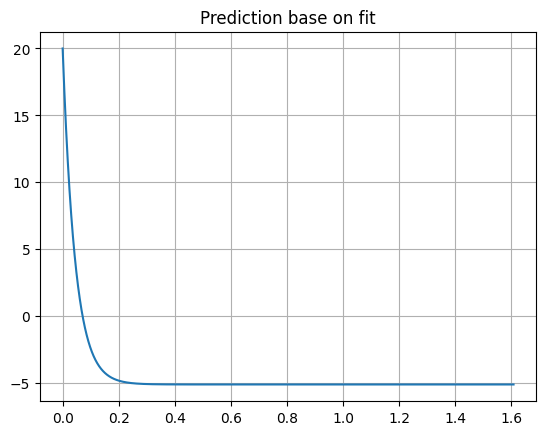

In [15]:
x = np.linspace(0,xdata.tolist()[-1]*5, 10000)
plt.plot(x, expfunc(x, *popt))
plt.title("Prediction base on fit")
plt.grid()
print(expfunc(1.5, *popt) )

[0.00050186 0.00625874] [5.70173351e-11 1.13536645e-10]


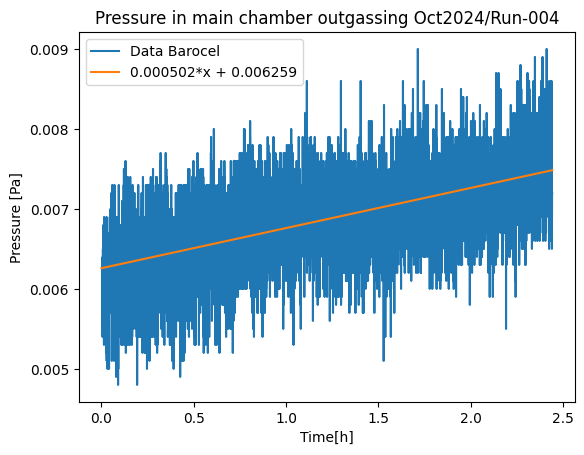

In [147]:
ydata = df["G5_Main_Barocel_value_1e7mbar"]*1e-7*100


func = linfunc
popt, pcov = curve_fit(func, xdata[data_start:data_stop],ydata[data_start:data_stop])#, p0=intial_guess, maxfev=10000 )
print(popt, np.diag(pcov))

plt.plot(xdata[data_start:data_stop], ydata[data_start:data_stop], label = "Data Barocel")
plt.plot(xdata, linfunc(xdata,*popt), label="{:.6f}*x + {:.6f}".format(*popt))
plt.xlabel("Time[h]")
plt.ylabel("Pressure [Pa]")
plt.title("Pressure in main chamber outgassing {}".format(month+run))
plt.legend()